In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from nilearn.plotting import plot_stat_map
from nilearn.image import load_img
import scipy.stats as stats
import nibabel as nib

In [2]:
def load_nifti_data(nifti_path):
    """Load NIfTI file and return data."""
    img = nib.load(nifti_path)
    data = img.get_fdata()
    return img, data

def calculate_lobular_median(data, mask, lobule_indices):
    """Calculate median thickness for each lobule based on the mask."""
    medians = {}
    for lobule in lobule_indices:
        lobule_mask = (mask == lobule)
        if np.any(lobule_mask):
            medians[lobule] = np.median(data[lobule_mask])
        else:
            medians[lobule] = np.nan
    return medians

def perform_linear_regression(Y, X):
    """Perform linear regression and return Beta, P-value, and Odds Ratio."""
    X_with_const = add_constant(X)
    ols_model = OLS(Y, X_with_const).fit()
    beta_group = ols_model.params['group']
    p_value_group = ols_model.pvalues['group']
    odds_ratio_group = np.exp(beta_group)
    
    return beta_group, p_value_group, odds_ratio_group


def save_nifti(data, affine, output_path):
    """Save NIfTI file."""
    new_img = nib.Nifti1Image(data, affine)
    nib.save(new_img, output_path)
    
def save_results_to_csv(lobule_results, output_path):
    """Save comparison results to a CSV file."""
    results_df = pd.DataFrame.from_dict(
        lobule_results,
        orient='index',
        columns=['Beta', 'Raw P-value', 'FDR P-value', 'Odds Ratio', '-log10(FDR P-value)']
    )
    results_df.index.name = 'Lobule'
    results_df.to_csv(output_path)

In [3]:
# Paths to NIfTI files for the groups and the lobular mask
group1_paths = [
    "../data/normal_yo_SCA/IXI158.nii",
    "../data/normal_yo_SCA/IXI204.nii",
    "../data/normal_yo_SCA/IXI237.nii",
    "../data/normal_yo_SCA/IXI251.nii",
    "../data/normal_yo_SCA/IXI288.nii",
    "../data/normal_yo_SCA/IXI383.nii",
    "../data/normal_yo_SCA/IXI384.nii",
    "../data/normal_yo_SCA/IXI399.nii",
    "../data/normal_yo_SCA/IXI420.nii",
    "../data/normal_yo_SCA/IXI433.nii",
    "../data/normal_yo_SCA/IXI462.nii",
    "../data/normal_yo_SCA/IXI464.nii",
    "../data/normal_yo_SCA/IXI476.nii",
    "../data/normal_yo_SCA/IXI491.nii",
    "../data/normal_yo_SCA/IXI498.nii",
    "../data/normal_yo_SCA/IXI518.nii",
    "../data/normal_yo_SCA/IXI538.nii",
]
group2_paths = [
    "../data/normal_yo_SCA/Patient1.nii",
    "../data/normal_yo_SCA/Patient2.nii",
    "../data/normal_yo_SCA/Patient3.nii",
    "../data/normal_yo_SCA/Patient4.nii",
    "../data/normal_yo_SCA/Patient5.nii",
    "../data/normal_yo_SCA/Patient6.nii",
    "../data/normal_yo_SCA/Patient8.nii",
    "../data/normal_yo_SCA/Patient9.nii",
    "../data/normal_yo_SCA/Patient10.nii",
    "../data/normal_yo_SCA/Patient11.nii",
    "../data/normal_yo_SCA/Patient12.nii",
]

group3_paths = [
    "../data/normal_yo_SCA/SCA013.nii",
    "../data/normal_yo_SCA/SCA029.nii",
    "../data/normal_yo_SCA/SCA033.nii",
    "../data/normal_yo_SCA/SCA039.nii",
    "../data/normal_yo_SCA/SCA068.nii",
    "../data/normal_yo_SCA/SCA069.nii",
    "../data/normal_yo_SCA/SCA076.nii",
    "../data/normal_yo_SCA/SCA077.nii",
    "../data/normal_yo_SCA/SCA083.nii",
    "../data/normal_yo_SCA/SCA084.nii",
    "../data/normal_yo_SCA/SCA087.nii",
    "../data/normal_yo_SCA/SCA090.nii",
    "../data/normal_yo_SCA/SCA093.nii",
    "../data/normal_yo_SCA/SCA094.nii",
    "../data/normal_yo_SCA/SCA095.nii",
    "../data/normal_yo_SCA/SCA096.nii",
    "../data/normal_yo_SCA/SCA097.nii",
]

lobular_mask_path = "../data/mni_structures_job1687583.nii"
results_dir = "../results/"

In [4]:
# Covariates (e.g., age and time to diagnosis)
group1_covariates = pd.DataFrame({
    'age': [75, 74, 78, 80, 78, 74, 74, 73, 73, 73, 75, 86, 78, 76, 77, 75, 82],
    #'time_to_diagnosis': [0] * 17
}, index=range(len(group1_paths)))

group2_covariates = pd.DataFrame({
    'age': [71, 62, 85, 79, 71, 63, 38, 67, 56, 71, 72],
    #'time_to_diagnosis': [8, 5, 4, 2, 4, 1, 11, 4, 10, 3, 9]
}, index=range(len(group1_paths), len(group1_paths) + len(group2_paths)))

group3_covariates = pd.DataFrame({
    'age': [42, 33, 24, 18, 35, 30, 49, 61, 66, 52, 49, 60, 46, 62, 56, 21, 61],
    #'time_to_diagnosis': [0] * 17
}, index=range(len(group1_paths) + len(group2_paths), len(group1_paths) + len(group2_paths) + len(group3_paths)))
 
# Load the lobular mask
mask_img, lobular_mask = load_nifti_data(lobular_mask_path)
lobule_indices = np.unique(lobular_mask)[np.unique(lobular_mask) > 0]  # Exclude background
lobule_indices = lobule_indices[~np.isin(lobule_indices, [13, 113])]

In [5]:
# Extract median thickness for each lobule
group1_medians = []
group2_medians = []
group3_medians = []

for g1_path in group1_paths:
    _, data = load_nifti_data(g1_path)
    group1_medians.append(calculate_lobular_median(data, lobular_mask, lobule_indices))

for g2_path in group2_paths:
    _, data = load_nifti_data(g2_path)
    group2_medians.append(calculate_lobular_median(data, lobular_mask, lobule_indices))

for g3_path in group3_paths:
    _, data = load_nifti_data(g3_path)
    group3_medians.append(calculate_lobular_median(data, lobular_mask, lobule_indices))

# Convert medians to DataFrame for easier handling
group1_medians_df = pd.DataFrame(group1_medians, index=group1_covariates.index)
group2_medians_df = pd.DataFrame(group2_medians, index=group2_covariates.index)
group3_medians_df = pd.DataFrame(group3_medians, index=group3_covariates.index)

In [6]:
#np.save('../data/group1_medians.npy', group1_data)
#np.save('../data/group2_medians.npy', group2_data)
#np.save('../data/group3_medians.npy', group3_data)

# Load the array
group1_medians = np.load('../data/group1_medians.npy')
group2_medians = np.load('../data/group2_medians.npy')
group3_medians = np.load('../data/group3_medians.npy')

In [7]:
def mean_and_std(df):
    # Flatten the DataFrame values to a single array
    mean_tn = df.mean(1)

    # Calculate the overall mean and standard deviation
    overall_mean = round(mean_tn.mean(), 2)
    overall_std = round(mean_tn.std(), 2)

    print(overall_mean, " +- ", overall_std)

mean_and_std(group1_medians_df)
mean_and_std(group2_medians_df)
mean_and_std(group3_medians_df)
mean_and_std(group2_medians_df)
mean_and_std(group2_medians_df.iloc[[0, 9, 10]])
mean_and_std(group2_medians_df.iloc[[1,2,3,4,5,6,7,8]])

3.11  +-  0.27
2.67  +-  1.25
2.83  +-  0.51
2.67  +-  1.25
1.0  +-  0.44
3.29  +-  0.74


In [8]:
labels = {
    1: 'Lobule I-II',
    2: 'Lobule III',
    3: 'Lobule IV',
    4: 'Lobule V',
    5: 'Lobule VI',
    6: 'Lobule Crus I',
    7: 'Lobule Crus II',
    8: 'Lobule VIIB',
    9: 'Lobule VIIIA',
    10: 'Lobule VIIIB',
    11: 'Lobule IX',
    12: 'Lobule X',
    101: 'Lobule I-II (R)',
    102: 'Lobule III (R)',
    103: 'Lobule IV (R)',
    104: 'Lobule V (R)',
    105: 'Lobule VI (R)',
    106: 'Lobule Crus I (R)',
    107: 'Lobule Crus II (R)',
    108: 'Lobule VIIB (R)',
    109: 'Lobule VIIIA (R)',
    110: 'Lobule VIIIB (R)',
    111: 'Lobule IX (R)',
    112: 'Lobule X (R)',
}

# Create a colormap for the labels
num_labels = len(labels)
colors = plt.cm.jet(np.linspace(0, 1, num_labels))
cmap = ListedColormap(colors)

lobule_names = [labels[value] for value in lobule_indices]

### All groups

In [9]:
# Add group labels
group1_covariates['group'] = 0
group2_covariates['group'] = 1
group3_covariates['group'] = 2

# Combine covariates and medians for all groups
combined_covariates = pd.concat([group1_covariates, group2_covariates, group3_covariates])
all_medians_df = pd.concat([group1_medians_df, group2_medians_df, group3_medians_df])

In [10]:
# Calculate medians for each group and lobule
group1_lobule_medians = group1_medians_df.median()
group2_lobule_medians = group2_medians_df.median()
group3_lobule_medians = group3_medians_df.median()

# Prepare a dictionary to store results
lobule_results = {}

# Initialize data arrays for visualization
beta_data = np.zeros_like(lobular_mask, dtype=float)
p_value_data12 = np.zeros_like(lobular_mask, dtype=float)
p_value_data23 = np.zeros_like(lobular_mask, dtype=float)
p_value_data13 = np.zeros_like(lobular_mask, dtype=float)
or_data = np.zeros_like(lobular_mask, dtype=float)

# Function to perform pairwise comparisons
def compare_groups(group1, group2, label1, label2, medians1, medians2):
    results = {}
    combined_indices = combined_covariates[
        combined_covariates['group'].isin([label1, label2])
    ].index
    pairwise_medians = all_medians_df.loc[combined_indices]
    pairwise_covariates = combined_covariates.loc[combined_indices]
    
    for lobule in lobule_indices:
        diff = pairwise_medians[lobule].dropna()  # Drop NaNs for the lobule
        if len(diff) > 1:
            covariates = pairwise_covariates.loc[diff.index]  # Align covariates
            beta, p_value, odds_ratio = perform_linear_regression(diff.values, covariates)
            t_stat, p_value_tstat = stats.ttest_ind(medians1[lobule], medians2[lobule], equal_var=False)

            results[lobule] = [beta, p_value, odds_ratio, t_stat, p_value_tstat]
        else:
            results[lobule] = [np.nan, np.nan, np.nan, np.nan, np.nan]
    
    return results

# Perform comparisons
results_1_vs_2 = compare_groups(group1_covariates, group2_covariates, 0, 1, group1_medians_df, group2_medians_df)
results_2_vs_3 = compare_groups(group2_covariates, group3_covariates, 1, 2, group2_medians_df, group3_medians_df)
results_1_vs_3 = compare_groups(group1_covariates, group3_covariates, 0, 2, group1_medians_df, group3_medians_df)

In [11]:
# Merge results and calculate FDR correction
all_results = {}
for lobule in lobule_indices:
    all_results[lobule] = {
        'Control_Median': group1_lobule_medians.get(lobule, np.nan),
        'Patient_Median': group2_lobule_medians.get(lobule, np.nan),
        'SCA_Median': group3_lobule_medians.get(lobule, np.nan),
        'Beta_1_vs_2': results_1_vs_2.get(lobule, [np.nan])[0],
        'P_1_vs_2': results_1_vs_2.get(lobule, [np.nan, np.nan])[1],
        'OddsRatio_1_vs_2': results_1_vs_2.get(lobule, [np.nan, np.nan, np.nan])[2],
        'P_1_vs_2_univariate': results_1_vs_2.get(lobule, [np.nan, np.nan])[4],
        'Beta_2_vs_3': results_2_vs_3.get(lobule, [np.nan])[0],
        'P_2_vs_3': results_2_vs_3.get(lobule, [np.nan, np.nan])[1],
        'OddsRatio_2_vs_3': results_2_vs_3.get(lobule, [np.nan, np.nan, np.nan])[2],
        'P_2_vs_3_univariate': results_2_vs_3.get(lobule, [np.nan, np.nan])[4],
        'Beta_1_vs_3': results_1_vs_3.get(lobule, [np.nan])[0],
        'P_1_vs_3': results_1_vs_3.get(lobule, [np.nan, np.nan])[1],
        'OddsRatio_1_vs_3': results_1_vs_3.get(lobule, [np.nan, np.nan, np.nan])[2],
        'P_1_vs_3_univariate': results_1_vs_3.get(lobule, [np.nan, np.nan])[4],
    }

In [12]:
# Apply FDR correction separately for each comparison
p_values_1_vs_2 = [all_results[lobule]['P_1_vs_2'] for lobule in lobule_indices]
p_values_2_vs_3 = [all_results[lobule]['P_2_vs_3'] for lobule in lobule_indices]
p_values_1_vs_3 = [all_results[lobule]['P_1_vs_3'] for lobule in lobule_indices]

p_values_1_vs_2_uni = [all_results[lobule]['P_1_vs_2_univariate'] for lobule in lobule_indices]
p_values_2_vs_3_uni = [all_results[lobule]['P_2_vs_3_univariate'] for lobule in lobule_indices]
p_values_1_vs_3_uni = [all_results[lobule]['P_1_vs_3_univariate'] for lobule in lobule_indices]

# Perform FDR correction for each set of p-values
fdr_corrected_1_vs_2 = multipletests(p_values_1_vs_2, method='fdr_bh')[1]
fdr_corrected_2_vs_3 = multipletests(p_values_2_vs_3, method='fdr_bh')[1]
fdr_corrected_1_vs_3 = multipletests(p_values_1_vs_3, method='fdr_bh')[1]

fdr_corrected_1_vs_2_uni = multipletests(p_values_1_vs_2_uni, method='fdr_bh')[1]
fdr_corrected_2_vs_3_uni = multipletests(p_values_2_vs_3_uni, method='fdr_bh')[1]
fdr_corrected_1_vs_3_uni = multipletests(p_values_1_vs_3_uni, method='fdr_bh')[1]

# Assign FDR-corrected P-values back to results
for idx, lobule in enumerate(lobule_indices):
    all_results[lobule]['FDR_P_1_vs_2'] = fdr_corrected_1_vs_2[idx]
    all_results[lobule]['FDR_P_2_vs_3'] = fdr_corrected_2_vs_3[idx]
    all_results[lobule]['FDR_P_1_vs_3'] = fdr_corrected_1_vs_3[idx]

    all_results[lobule]['FDR_P_1_vs_2_univariate'] = fdr_corrected_1_vs_2_uni[idx]
    all_results[lobule]['FDR_P_2_vs_3_univariate'] = fdr_corrected_2_vs_3_uni[idx]
    all_results[lobule]['FDR_P_1_vs_3_univariate'] = fdr_corrected_1_vs_3_uni[idx]

    p_value_data12[lobular_mask == lobule] = -np.log10(fdr_corrected_1_vs_2[idx]) if fdr_corrected_1_vs_2[idx] > 0 else 0
    p_value_data23[lobular_mask == lobule] = -np.log10(fdr_corrected_2_vs_3[idx]) if fdr_corrected_2_vs_3[idx] > 0 else 0
    p_value_data13[lobular_mask == lobule] = -np.log10(fdr_corrected_1_vs_3[idx]) if fdr_corrected_1_vs_3[idx] > 0 else 0


# Convert results to DataFrame and save
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df.index.name = 'Lobule'
results_csv_path = os.path.join(results_dir, "pairwise_comparisons_results.csv")
results_df.to_csv(results_csv_path)

print(f"Pairwise comparisons saved to {results_csv_path}")


Pairwise comparisons saved to ../results/pairwise_comparisons_results.csv


In [13]:
# Modify the results dictionary to include only the required metrics
all_results_filtered = {}
for lobule in lobule_indices:
    all_results_filtered[lobule] = {
        ("Median Thickness", "Control"): group1_lobule_medians.get(lobule, np.nan),
        ("Median Thickness", "Patient"): group2_lobule_medians.get(lobule, np.nan),
        ("Median Thickness", "SCA"): group3_lobule_medians.get(lobule, np.nan),
        ("Patient vs Control", "p-value univar"): all_results[lobule]['FDR_P_1_vs_2_univariate'],
        ("Patient vs Control", "Beta"): results_1_vs_2.get(lobule, [np.nan])[0],
        ("Patient vs Control", "p-value multivar"): all_results[lobule]['FDR_P_1_vs_2'],
        ("Patient vs SCA", "p-value univar"): all_results[lobule]['FDR_P_2_vs_3_univariate'],
        ("Patient vs SCA", "Beta"): results_2_vs_3.get(lobule, [np.nan])[0],
        ("Patient vs SCA", "p-value multivar"): all_results[lobule]['FDR_P_2_vs_3'],
        ("Control vs SCA", "p-value univar"): all_results[lobule]['FDR_P_1_vs_3_univariate'],
        ("Control vs SCA", "Beta"): results_1_vs_3.get(lobule, [np.nan])[0],
        ("Control vs SCA", "p-value multivar"): all_results[lobule]['FDR_P_1_vs_3'],
    }

# Convert to DataFrame
results_df_filtered = pd.DataFrame.from_dict(all_results_filtered, orient='index')
results_df_filtered.index = results_df_filtered.index.map(labels)

# Define MultiIndex for the columns
results_df_filtered.columns = pd.MultiIndex.from_tuples(results_df_filtered.columns)

# Set the index name for clarity
results_df_filtered.index.name = "Lobule"

# Save the filtered multi-header DataFrame
results_csv_path_filtered = os.path.join(results_dir, "pairwise_comparisons_results_filtered.csv")
results_df_filtered.to_csv(results_csv_path_filtered)

print(f"Filtered pairwise comparisons with multi-header saved to {results_csv_path_filtered}")

# Display the DataFrame for verification
print(results_df_filtered)


Filtered pairwise comparisons with multi-header saved to ../results/pairwise_comparisons_results_filtered.csv
                   Median Thickness                     Patient vs Control  \
                            Control   Patient       SCA     p-value univar   
Lobule                                                                       
Lobule I-II                1.479226  0.064694  0.561410           0.758405   
Lobule III                 2.058685  1.784195  1.732671           0.921478   
Lobule IV                  4.598509  3.118885  4.748646           0.080225   
Lobule V                   4.752987  4.035964  5.019249           0.080225   
Lobule VI                  4.782900  4.177687  4.779464           0.211742   
Lobule Crus I              3.173704  1.462709  3.152234           0.406551   
Lobule Crus II             2.546013  3.216722  3.197644           0.623123   
Lobule VIIB                2.771021  4.048000  3.653757           0.211742   
Lobule VIIIA               4.184

### 3D plotting

In [14]:
# Save NIfTI file
save_nifti(p_value_data12, mask_img.affine, os.path.join(results_dir, "lobular_neg_log_p_values_12.nii"))
save_nifti(p_value_data23, mask_img.affine, os.path.join(results_dir, "lobular_neg_log_p_values_23.nii"))
save_nifti(p_value_data13, mask_img.affine, os.path.join(results_dir, "lobular_neg_log_p_values_13.nii"))

In [15]:
def plot_nifti_with_legend(nifti_path, title, output_path=None, threshold=None, colormap="viridis"):
    """
    Plot a NIfTI file with a legend using nilearn.

    Parameters:
    - nifti_path: str
        Path to the NIfTI file.
    - title: str
        Title for the plot.
    - output_path: str or None
        Path to save the plot as an image file. If None, the plot is not saved.
    - threshold: float or None
        Minimum value to display. Values below this are not shown.
    - colormap: str
        Colormap to use for the plot (e.g., 'viridis', 'hot').

    Returns:
    - None
    """
    # Load the NIfTI file
    img = load_img(nifti_path)

    # Plot the NIfTI file
    display = plot_stat_map(
        img,
        title=title,
        colorbar=True,
        threshold=threshold,
        display_mode="ortho",  # Show axial, sagittal, and coronal views
        cmap=colormap,  # Set the colormap
        dim=-0.5,  # Adjust contrast for visibility
    )
    
    # Save the plot if output_path is specified
    if output_path:
        display.savefig(output_path)
        print(f"Plot saved to {output_path}")

    # Close the display to free resources
    display.close()
    
plot_nifti_with_legend(os.path.join(results_dir, "lobular_neg_log_p_values_12.nii"), "-log10(FDR-Corrected P-Values) Patient vs Healthy", os.path.join(results_dir, "12.png"), colormap="viridis")
plot_nifti_with_legend(os.path.join(results_dir, "lobular_neg_log_p_values_23.nii"), "-log10(FDR-Corrected P-Values) Patient vs SCA", os.path.join(results_dir, "23.png"), colormap="viridis")
plot_nifti_with_legend(os.path.join(results_dir, "lobular_neg_log_p_values_13.nii"), "-log10(FDR-Corrected P-Values) Healthy vs SCA", os.path.join(results_dir, "13.png"), colormap="viridis")

Plot saved to ../results/12.png
Plot saved to ../results/23.png
Plot saved to ../results/13.png


In [16]:
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

beta_img = load_img(os.path.join(results_dir, "lobular_neg_log_p_values_12.nii"))
beta_fdata = beta_img.get_fdata()
affine = beta_img.affine

significant_voxels = np.where(beta_fdata != 0)
significant_coords = nib.affines.apply_affine(affine, np.vstack(significant_voxels).T)

df_coord = pd.DataFrame(significant_coords, columns=['x', 'y', 'z'])
df_coord['-log10(p-value)'] = beta_fdata[significant_voxels]

# Plot in 3D with Plotly
fig = px.scatter_3d(
    df_coord, x='x', y='y', z='z', color='-log10(p-value)',
    color_continuous_scale='viridis',  # Red for positive, blue for negative
    title='Patients vs control',
    labels={'color': '-log10(p-value)'},
)

fig.update_traces(marker=dict(size=2))  # Adjust marker size
fig.show()

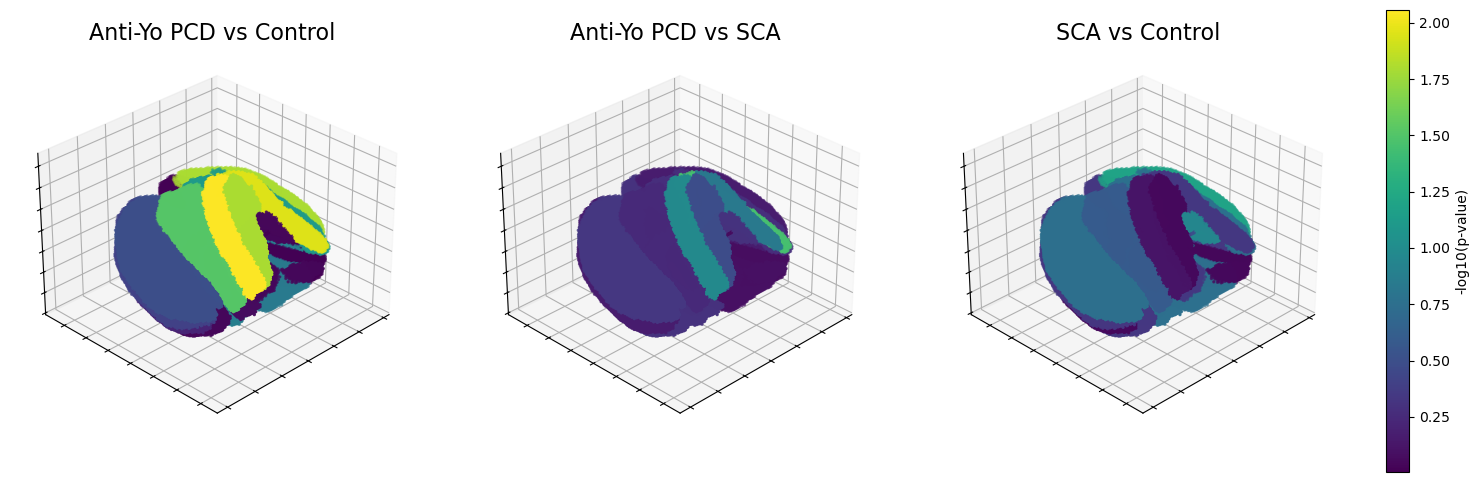

In [17]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the filenames
files = [
    "lobular_neg_log_p_values_12.nii",
    "lobular_neg_log_p_values_23.nii",
    "lobular_neg_log_p_values_13.nii"
]

# Titles for the plots
titles = ["Anti-Yo PCD vs Control", "Anti-Yo PCD vs SCA", "SCA vs Control"]

# Initialize the plot
fig = plt.figure(figsize=(18, 6))  # 3 plots horizontally

# Initialize a list to store the color values (to find the global min and max for color scale)
color_values = []

# Create 3D subplots (1 row, 3 columns)
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# List of axes for easy iteration
axes = [ax1, ax2, ax3]

# Loop through the files to create the plots
for i, file in enumerate(files):
    # Load the NIfTI image
    beta_img = nib.load(os.path.join(results_dir, file))
    beta_fdata = beta_img.get_fdata()
    affine = beta_img.affine
    
    # Get the significant voxels
    significant_voxels = np.where(beta_fdata != 0)
    significant_coords = nib.affines.apply_affine(affine, np.vstack(significant_voxels).T)
    
    # Create a DataFrame for the coordinates and p-values
    df_coord = pd.DataFrame(significant_coords, columns=['x', 'y', 'z'])
    df_coord['-log10(p-value)'] = beta_fdata[significant_voxels]
    
    # Collect color values for the global color scale
    color_values.extend(df_coord['-log10(p-value)'])
    
    # Plotting the scatter plot for each file
    scatter = axes[i].scatter(
        df_coord['x'], 
        df_coord['y'], 
        df_coord['z'], 
        c=df_coord['-log10(p-value)'], 
        cmap='viridis', 
        s=2
    )
    
    # Set title and labels for each subplot
    axes[i].set_title(titles[i], fontsize=16)
    #axes[i].set_xlabel('X Coordinate')
    #axes[i].set_ylabel('Y Coordinate')
    #axes[i].set_zlabel('Z Coordinate')
    axes[i].view_init(elev=30, azim=45)
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].set_zticklabels([])

# Find the global min and max values for color scaling
vmin = min(color_values)
vmax = max(color_values)

# Set the color scale to be consistent across all subplots
for ax in axes:
    scatter = ax.collections[0]
    scatter.set_clim(vmin=vmin, vmax=vmax)

# Add a shared colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('-log10(p-value)')

# Show the plot
plt.savefig('../results/p_values.svg', bbox_inches='tight')
plt.show()


### Covariate effect

In [18]:
# Covariates (e.g., age and time to diagnosis)
group1_covariates = pd.DataFrame({
    'age': [75, 74, 78, 80, 78, 74, 74, 73, 73, 73, 75, 86, 78, 76, 77, 75, 82],
    'time_to_diagnosis': [0] * 17
}, index=range(len(group1_paths)))

group2_covariates = pd.DataFrame({
    'age': [71, 62, 85, 79, 71, 63, 38, 67, 56, 71, 72],
    'time_to_diagnosis': [8, 5, 4, 2, 4, 1, 11, 4, 10, 3, 9]
}, index=range(len(group1_paths), len(group1_paths) + len(group2_paths)))

group3_covariates = pd.DataFrame({
    'age': [42, 33, 24, 18, 35, 30, 49, 61, 66, 52, 49, 60, 46, 62, 56, 21, 61],
    'time_to_diagnosis': [0] * 17
}, index=range(len(group1_paths) + len(group2_paths), len(group1_paths) + len(group2_paths) + len(group3_paths)))


# Combine covariates and medians for all groups
combined_covariates = pd.concat([group1_covariates, group2_covariates, group3_covariates])
all_medians_df = pd.concat([group1_medians_df, group2_medians_df, group3_medians_df])

In [19]:
group1_lobule_medians = group1_medians_df.median()
group2_lobule_medians = group2_medians_df.median()
group3_lobule_medians = group3_medians_df.median()

# Prepare a dictionary to store results
lobule_results = {}

In [20]:
# Prepare the design matrix
X = group2_covariates.copy()
X = add_constant(X)

# Initialize lists to store results
coefficients_list = []
p_values_list = []

# Loop through each column in the medians DataFrame
for col in all_medians_df.columns:
    y = group2_medians_df[col]
    
    # Fit the model
    model = OLS(y, X).fit()
    
    # Extract coefficients and p-values (excluding intercept)
    coefficients = model.params[1:]  # Exclude intercept
    p_values = model.pvalues[1:]     # Exclude intercept
    
    coefficients_list.append(coefficients)
    p_values_list.append(p_values)

# Create DataFrames for coefficients and p-values
coefficients_df = pd.DataFrame(coefficients_list, columns=["age", "time_to_diagnosis"], index=group2_medians_df.columns)
p_values_df = pd.DataFrame(p_values_list, columns=["age", "time_to_diagnosis"], index=group2_medians_df.columns)

# Combine into a single DataFrame with a double header
combined_df = pd.concat([coefficients_df, p_values_df], keys=["Coefficient", "P-value"], axis=1)

# Adjust p-values for multiple comparisons
adjusted_p_values = p_values_df.apply(lambda col: multipletests(col, method="fdr_bh")[1])

combined_df.index = combined_df.index.map(labels)

# Set the index name for clarity
combined_df.index.name = "Lobule"

# Reset index to include it as a column
combined_df = combined_df.reset_index()
combined_df.rename(columns={"index": "Lobule"}, inplace=True)

# Save the DataFrame to Excel
#combined_df.to_excel("../results/regression_results.xlsx", index=False)

# Assuming your index or a column distinguishes left/right (e.g., 'Lobule' column)
left_df = combined_df[combined_df['Lobule'].str.contains('Left|left|Lobule I|Lobule III|Lobule IV|Lobule V|Lobule VI|Lobule Crus I|Lobule Crus II|Lobule VIIB|Lobule VIIIA|Lobule VIIIB|Lobule IX|Lobule X')]
right_df = combined_df[~combined_df.index.isin(left_df.index)]

with pd.ExcelWriter("../results/regression_results.xlsx") as writer:
    left_df.to_excel(writer, sheet_name="Left Hemisphere")
    right_df.to_excel(writer, sheet_name="Right Hemisphere")

/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40789/1284845882.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40789/1284845882.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



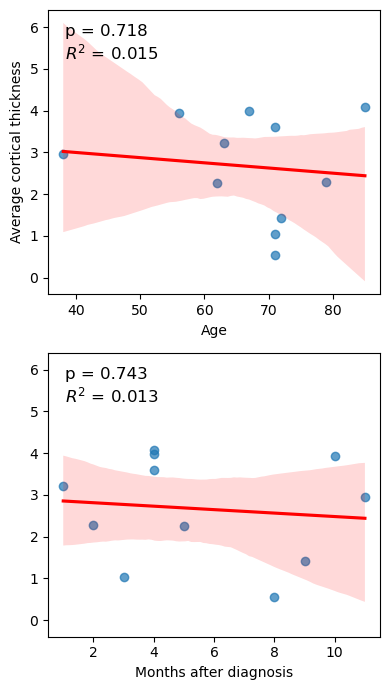

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant

# Calculate global thickness (averaged across all lobules)
global_thickness = group2_medians_df.mean(axis=1)

# Prepare data for plotting
data = group2_covariates.copy()
data['global_thickness'] = global_thickness

# Create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(4, 7), sharey=True)

def get_p_value_and_r2(x, y):
    X = add_constant(x)  # Add intercept
    model = OLS(y, X).fit()
    p_value = model.pvalues[1]  # p-value for the slope
    r_squared = model.rsquared  # R-squared value
    return p_value, r_squared

# Calculate p-values and R-squared values
p_value_age, r2_age = get_p_value_and_r2(data['age'], data['global_thickness'])
p_value_time_to_diagnosis, r2_time_to_diagnosis = get_p_value_and_r2(data['time_to_diagnosis'], data['global_thickness'])

# Scatter plot: Global Thickness vs Age
sns.regplot(
    x='age',
    y='global_thickness',
    data=data,
    ax=axes[0],
    scatter_kws={'alpha': 0.7},
    line_kws={'color': 'red'}
)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Average cortical thickness')
axes[0].text(
    0.05, 0.95, 
    f'p = {p_value_age:.3g}\n$R^2$ = {r2_age:.3f}', 
    transform=axes[0].transAxes, 
    fontsize=12, verticalalignment='top'
)

# Scatter plot: Global Thickness vs Time to Diagnosis
sns.regplot(
    x='time_to_diagnosis',
    y='global_thickness',
    data=data,
    ax=axes[1],
    scatter_kws={'alpha': 0.7},
    line_kws={'color': 'red'}
)
axes[1].set_xlabel('Months after diagnosis')
axes[1].set_ylabel('')
axes[1].text(
    0.05, 0.95, 
    f'p = {p_value_time_to_diagnosis:.3g}\n$R^2$ = {r2_time_to_diagnosis:.3f}', 
    transform=axes[1].transAxes, 
    fontsize=12, verticalalignment='top'
)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('../results/age_time_diagnosis_covariates.svg', bbox_inches='tight')
plt.show()